In [1]:
from naqst import *

In [2]:
path = "bench/"
files = os.listdir(path)
file_name = files[0]
print(file_name)


qft_5.qasm


In [3]:
# circuit = CreateCircuitFromQASM(file_name, path)
circuit = QuantumCircuit.from_qasm_file(path+file_name)
#transform to cz-based circuit
cz_circuit = transpile(circuit, basis_gates=['cz', 'rx', 'ry', 'rz', 'h', 't'])
#cz gates list
gate_2q_list = get_2q_gates_list(cz_circuit)
#obtain corresponding DAG
_ , dag = gates_list_to_QC(gate_2q_list)

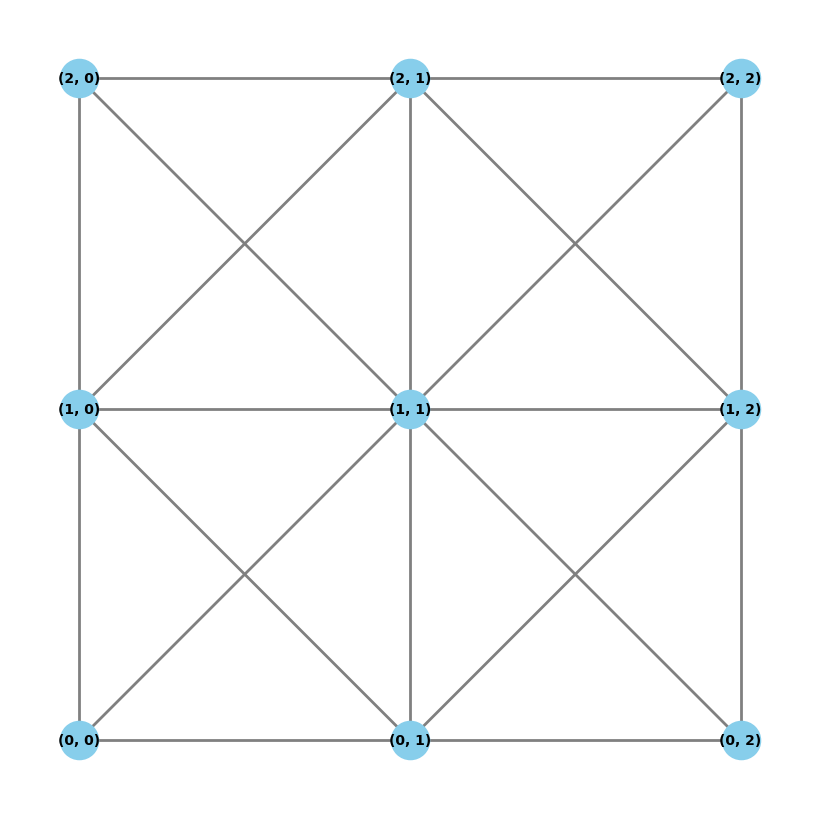

In [4]:
#gate_num = len(gate_2q_list)
#obtain the qubits number
num_q = qubits_num(gate_2q_list)
#print("Num of gates", gate_num)

# use some more flexable way to set arch_size
# n = 3
# arch_size = math.ceil(math.sqrt(num_q)) + n
arch_size = 3
Rb = math.sqrt(2)
#obtain the corresponding coupling_graph 
coupling_graph = generate_grid_with_Rb(arch_size,arch_size, Rb)

import matplotlib.pyplot as plt
pos = {(x, y): (y, x) for x, y in coupling_graph.nodes()}

# Draw the graph with a customized style
plt.figure(figsize=(8, 8))
nx.draw(coupling_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=10, font_color='black', font_weight='bold', linewidths=2, width=2)
plt.show()

In [5]:
#obtain the gates partition
partition_gates = parition_from_DAG(dag, coupling_graph)
print("------------------------------")
part_gate_num = sum(len(gates) for gates in partition_gates)
print("final num is:", part_gate_num)

#for each partition, find a proper embedding
embeddings = []

for i in range(len(partition_gates)):
    tmp_graph = nx.Graph()
    tmp_graph.add_edges_from(partition_gates[i])
    next_embedding = get_rx_subg_mapping(tmp_graph, coupling_graph)
    embeddings.append(map2list(next_embedding,num_q))
print(embeddings)

for i in range(len(embeddings)):
    indices = [index for index, value in enumerate(embeddings[i]) if value == -1]
    if indices:
        if i != 0:
            pre_map = embeddings[i-1]
        else:
            pre_map = []
        if i != len(embeddings) -1:
            post_map = embeddings[i+1]
        else:
            post_map = []
        embeddings[i] = complete_mapping(i, embeddings, indices, coupling_graph)
print(embeddings)

------------------------------
final num is: 20
[[(1, 1), (2, 1), (1, 0), (2, 0), (2, 2)], [-1, -1, (2, 2), (2, 1), (1, 1)]]
[[(1, 1), (2, 1), (1, 0), (2, 0), (2, 2)], [(0, 0), (1, 0), (2, 2), (2, 1), (1, 1)]]


In [6]:
from networkx import maximal_independent_set, Graph
import subprocess

def compatible_2D(a: list[int], b: list[int]) -> bool:
    assert len(a) == 4 and len(b) == 4, "Both arguments must be lists with exactly four elements."

    if a[0] == b[0] and a[1] != b[1]:
        return False
    if a[1] == b[1] and a[0] != b[0]:
        return False
    if a[0] < b[0] and a[1] >= b[1]:
        return False
    if a[0] > b[0] and a[1] <= b[1]:
        return False

    if a[2] == b[2] and a[3] != b[3]:
        return False
    if a[3] == b[3] and a[2] != b[2]:
        return False
    if a[2] < b[2] and a[3] >= b[3]:
        return False
    if a[2] > b[2] and a[3] <= b[3]:
        return False

    return True
def maximalis_solve_sort(n: int, edges: list[tuple[int]], nodes: set[int]) -> list[int]:
    # assum the vertices are sorted based on qubit distance
    is_node_conflict = [False for _ in range(n)]
    node_neighbors = {i: [] for i in range(n)}
    for edge in edges:
        node_neighbors[edge[0]].append(edge[1])
        node_neighbors[edge[1]].append(edge[0])
    result = []
    for i in nodes:
        if is_node_conflict[i]:
            continue
        else:
            result.append(i)
            for j in node_neighbors[i]:
                is_node_conflict[j] = True
    return result

def maximalis_solve(nodes, edges):
    G = Graph()
    for i in nodes:
        G.add_node(i)
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    result = maximal_independent_set(G, seed=0) 
    return result

In [7]:
def get_movement(current_map:list,next_map:list,window_size = None)-> map:
    # example: current_map = [(1, 1), (0, 1), (1, 0), (0, 0), (1, 2)]
    # next_map = [(1, 1), (0, 0), (2, 2), (0, 1), (1, 2)]
    movements = {}
    # Determine movements of qubits
    for qubit, current_position in enumerate(current_map):
        next_position = next_map[qubit]
        if current_position != next_position:
            move_details = current_position + next_position
            movements[qubit] = move_details
    return movements

def solve_violations(movements,violations,sorted_keys,routing_strategy,num_q,layer):
    # print(f'Movements: {movements}')
    # print(f'Violations: {violations}')
    if routing_strategy == "maximalis":
        resolution_order = maximalis_solve(sorted_keys, violations)
    else:
        resolution_order = maximalis_solve_sort(num_q, violations,sorted_keys)
    print(f'Resolution Order: {resolution_order}')
    
    layer = copy.deepcopy(layer)
    for qubit in resolution_order:
        sorted_keys.remove(qubit)
        
        move = movements[qubit]
        print(f'Move qubit {qubit} from ({move[0]}, {move[1]}) to ({move[2]}, {move[3]})')
        for qubit_ in layer["qubits"]:
            if qubit_["id"] == qubit:
                qubit_["a"] = 1
        
        # Remove resolved violations
        violations = [v for v in violations if qubit not in v]
        del movements[qubit]
    
    return layer,movements,violations

def map_to_layer(map:list)-> map:
    return {
        "qubits": [{
            "id": i,
            "a": 0,
            "x": map[i][0],
            "y": map[i][1],
            "c": map[i][0],
            "r": map[i][1],
        } for i in range(len(map))],
        "gates": []
    }

In [8]:
window = False
window_size = 1000
routing_strategy = "maximalis"
import copy

layers = []
layers.append(map_to_layer(embeddings[0]))
for i in range(len(embeddings) - 1):
    current_map = embeddings[i]
    next_map = embeddings[i + 1]
    next_layer = map_to_layer(next_map)
    
    last_layer = copy.deepcopy(layers[-1])
    movements = get_movement(current_map,next_map)
    # Sort movements by distance in descending order
    sorted_keys = sorted(movements.keys(), key=lambda k: math.dist((movements[k][0], movements[k][1]), (movements[k][2], movements[k][3])), reverse=False)
    print(f'sorted_keys:{sorted_keys}')
    
    # Check for violations
    violations = []
    for i in range(len(sorted_keys)):
        for j in range(i + 1, len(sorted_keys)):
            if not compatible_2D(movements[sorted_keys[i]], movements[sorted_keys[j]]):
                violations.append((sorted_keys[i], sorted_keys[j]))

    # print(f'Violations: {violations}')
    
    # Resolve violations
    while violations:
        new_layer,movements,violations = solve_violations(movements,violations,sorted_keys,routing_strategy,num_q,last_layer)
        layers.append(new_layer)
        for i in range(num_q):
            if new_layer["qubits"][i]["a"] == 1:
                last_layer["qubits"][i] = next_layer["qubits"][i]
            
    if movements:
        for qubit in movements:
            move = movements[qubit]
            for qubit_ in last_layer["qubits"]:
                if qubit_["id"] == qubit:
                    qubit_["a"] = 1
        layers.append(last_layer)
    layers.append(next_layer)
    
            
data = {
    # "runtime": float(time.time() - start_time),
    "no_transfer": False,
    "layers": layers,
    "n_q": num_q,
    # "g_q": list_gates,
}
layers

sorted_keys:[3, 0, 1, 4, 2]
Resolution Order: [4, 2]
Move qubit 4 from (2, 2) to (1, 1)
Move qubit 2 from (1, 0) to (2, 2)
Resolution Order: [0]
Move qubit 0 from (1, 1) to (0, 0)
Resolution Order: [1]
Move qubit 1 from (2, 1) to (1, 0)


[{'qubits': [{'id': 0, 'a': 0, 'x': 1, 'y': 1, 'c': 1, 'r': 1},
   {'id': 1, 'a': 0, 'x': 2, 'y': 1, 'c': 2, 'r': 1},
   {'id': 2, 'a': 0, 'x': 1, 'y': 0, 'c': 1, 'r': 0},
   {'id': 3, 'a': 0, 'x': 2, 'y': 0, 'c': 2, 'r': 0},
   {'id': 4, 'a': 0, 'x': 2, 'y': 2, 'c': 2, 'r': 2}],
  'gates': []},
 {'qubits': [{'id': 0, 'a': 0, 'x': 1, 'y': 1, 'c': 1, 'r': 1},
   {'id': 1, 'a': 0, 'x': 2, 'y': 1, 'c': 2, 'r': 1},
   {'id': 2, 'a': 1, 'x': 1, 'y': 0, 'c': 1, 'r': 0},
   {'id': 3, 'a': 0, 'x': 2, 'y': 0, 'c': 2, 'r': 0},
   {'id': 4, 'a': 1, 'x': 2, 'y': 2, 'c': 2, 'r': 2}],
  'gates': []},
 {'qubits': [{'id': 0, 'a': 1, 'x': 1, 'y': 1, 'c': 1, 'r': 1},
   {'id': 1, 'a': 0, 'x': 2, 'y': 1, 'c': 2, 'r': 1},
   {'id': 2, 'a': 0, 'x': 2, 'y': 2, 'c': 2, 'r': 2},
   {'id': 3, 'a': 0, 'x': 2, 'y': 0, 'c': 2, 'r': 0},
   {'id': 4, 'a': 0, 'x': 1, 'y': 1, 'c': 1, 'r': 1}],
  'gates': []},
 {'qubits': [{'id': 0, 'a': 0, 'x': 0, 'y': 0, 'c': 0, 'r': 0},
   {'id': 1, 'a': 1, 'x': 2, 'y': 1, 'c': 2, 